In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
import scipy.stats as stats
import pandas_profiling as pp
import statsmodels.api as sm
import pylab
import itertools
import scipy

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import (RFE, f_regression)
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from patsy import dmatrices
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2


#### create  an excel file for output - Regression results.xlsx

In [2]:
#pip install  openpyxl

In [3]:
writer = pd.ExcelWriter

In [4]:
writer = pd.ExcelWriter('Final Summary.xlsx')

In [5]:
# Importing the data
credit_data = pd.read_excel("Data Set.xlsx", na_values= ['#NULL!'])
credit_data.head(3)

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0


In [6]:
credit_data.head(5)

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [7]:
# info of the data
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [8]:
credit_data.select_dtypes('object')

,custid,birthmonth
0,3964-QJWTRG-NPN,September
1,0648-AIPJSP-UVM,May
2,5195-TLUDJE-HVO,June
3,4459-VLPQUH-3OL,May
4,8158-SMTQFB-CNO,July
...,...,...
4995,3675-GZFGOT-QJN,January
4996,4699-LEPCCE-3UD,May
4997,8485-LLUICH-CVV,August
4998,9325-URAAUT-7FA,December


In [9]:
# Shape of the data
credit_data.shape

(5000, 130)

### creating the dependent varable total spend and droping the cardspent and card2spent

In [10]:
# as  we are going to do prediction on total spend so summing both the coloumns of credit card spent
credit_data['total_spent'] = credit_data['cardspent'] + credit_data['card2spent']
credit_data.drop(['cardspent', 'card2spent'], axis= 1, inplace= True)

### indentifying the numeric and categorical variables

In [11]:
# dropping the custid as we dont need this column in further analysis
credit_data.drop(['custid', 'birthmonth'], axis= 1, inplace= True)

In [12]:
# reading data dictionary
data_dictionary = pd.read_excel("Data Dictionary.xlsx")

In [13]:
data_dictionary.head(3)

,Numeric Variable,Label,Unnamed: 2,Categorical Variable,Unnamed: 4,Label.1
0,custid,Customer ID,NaN,region,1,Zone 1
1,region,Geographic indicator,NaN,NaN,2,Zone 2
2,townsize,Size of hometown,NaN,NaN,3,Zone 3


In [14]:
# reading categorical variables from the variable (categorical variable) and save it in to a list
cat_vars = list(data_dictionary['Categorical Variable'].dropna())
cat_vars.remove('birthmonth')
len(cat_vars)

83

In [15]:
numerical_vars = []
for i in credit_data.columns:
    if i not in cat_vars:
        numerical_vars.append(i)
len(numerical_vars)

44

In [16]:
print('Total Columns: ' , len(credit_data.columns))
print('Total Categorical Columns: ', len(cat_vars))


print('Total Continous Columns: ', len(numerical_vars))

Total Columns:  127
Total Categorical Columns:  83
Total Continous Columns:  44


In [17]:
credit_data[cat_vars] = credit_data[cat_vars].astype('category')


In [18]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 127 entries, region to total_spent
dtypes: category(83), float64(29), int64(15)
memory usage: 2.1 MB


### Data Summary

#### create UDF's

In [19]:
def continous_summary(var):
    return(pd.Series([var.count(), var.isnull().sum(), var.sum(), var.mean(), var.median(), var.std(), var.var(), var.min(), var.dropna().quantile(0.01),
                     var.dropna().quantile(0.05), var.dropna().quantile(0.10), var.dropna().quantile(0.25),var.dropna().quantile(0.5),
                     var.dropna().quantile(0.75),var.dropna().quantile(0.90), var.dropna().quantile(0.95),var.dropna().quantile(0.99),
                     var.dropna().max()], 
                                index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,
                                         'P75' ,'P90' ,'P95' ,'P99' ,'MAX']))
            

In [20]:
# Summary for categorical variables
def categorical_summary(x):
    return(pd.Series([x.count(), x.isna().sum(), x.value_counts()],
                    index = ['N', 'NMISS', 'Values In Column']))

In [21]:
def list_update(var):
    if var in cat_vars:
        cat_vars.remove(var)
    elif var in numerical_vars:
        numerical_vars.remove(var)
    else:
        print('This variable is not present in either of the list.')
        
# UDF to drop all the variables in given list from main dataset
def list_drop(ldc):
    for var in ldc:
        list_update(var)
        credit_data.drop(var, axis=1 , inplace=True)
        credit_conti_var = credit_data.loc[:, numerical_vars]
        credit_cat_var = credit_data.loc[:, cat_vars]

In [22]:
# Dummy creation
def create_dummies( credits_cat, colname ):
    col_dummies = pd.get_dummies(credits_cat[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    credits_cat = pd.concat([credits_cat, col_dummies], axis=1)
    credits_cat.drop( colname, axis = 1, inplace = True )
    return credits_cat

### Checking Assumption for LR

C:\pyhton\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


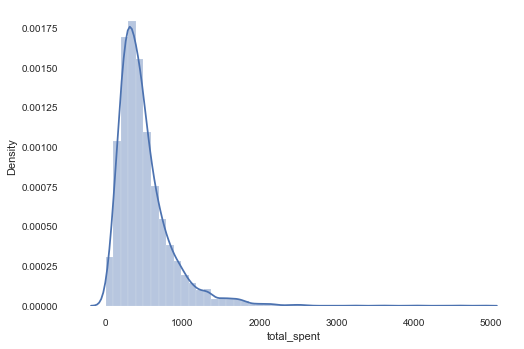

In [23]:
sns.distplot(credit_data.total_spent)
plt.show()

#### total spent is highly skewed , log can take care of it to some extent

In [24]:
credit_data['ln_total_spent'] = np.log(credit_data['total_spent'])


In [25]:
list_drop(['total_spent'])
numerical_vars.append('ln_total_spent')

C:\pyhton\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


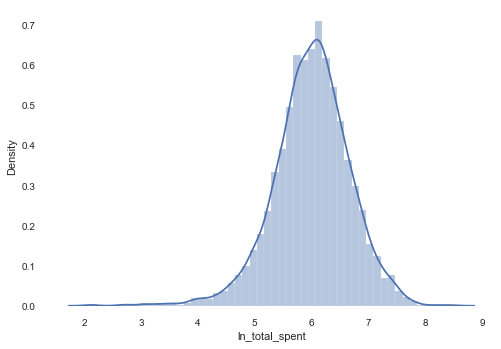

In [26]:
sns.distplot(credit_data.ln_total_spent)
plt.show()

### Missing Value Checking

In [27]:
credit_data.isnull().sum().value_counts()

0       112
2         3
3296      2
3656      2
2622      2
3         2
1         2
1422      1
1419      1
dtype: int64

In [28]:
credit_conti_var = credit_data.loc[:, numerical_vars]
missing_value = pd.DataFrame(credit_conti_var.apply(continous_summary).T.round(1)['NMISS']/ 5000 * 100)
M_value = missing_value[missing_value['NMISS'] > 25]
M_value

,NMISS
lntollmon,52.44
lntollten,52.44
lnequipmon,65.92
lnequipten,65.92
lncardmon,28.38
lncardten,28.44
lnwiremon,73.12
lnwireten,73.12


In [29]:
M_value.to_excel(writer, 'High_missing', index= True)

In [30]:
list_drop(M_value.index)
credit_conti_var.drop(M_value.index,axis= 1,  inplace=True)
credit_data.shape

(5000, 119)

In [31]:
credit_data.isna().sum().value_counts()

0    112
2      3
3      2
1      2
dtype: int64

#### Numerical Summary

In [32]:
num_summary = credit_conti_var.apply(continous_summary).T.round(2)
num_summary.to_excel(writer, sheet_name = 'Continous_Variable_Summary', index = True)

In [33]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,5000.0,0.0,235128.00,47.03,47.00,17.77,315.78,18.00,18.00,20.00,23.00,31.00,47.00,62.00,72.00,76.00,79.00,79.00
ed,5000.0,0.0,72715.00,14.54,14.00,3.28,10.77,6.00,8.00,9.00,10.00,12.00,14.00,17.00,19.00,20.00,21.00,23.00
income,5000.0,0.0,273798.00,54.76,38.00,55.38,3066.67,9.00,9.00,13.00,16.00,24.00,38.00,67.00,109.10,147.00,272.01,1073.00
lninc,5000.0,0.0,18499.55,3.70,3.64,0.75,0.56,2.20,2.20,2.56,2.77,3.18,3.64,4.20,4.69,4.99,5.61,6.98
debtinc,5000.0,0.0,49770.80,9.95,8.80,6.40,40.96,0.00,0.70,1.90,2.80,5.10,8.80,13.60,18.60,22.20,29.20,43.10
creddebt,5000.0,0.0,9286.63,1.86,0.93,3.42,11.67,0.00,0.03,0.10,0.18,0.39,0.93,2.06,4.30,6.37,14.28,109.07
lncreddebt,4999.0,1.0,-652.14,-0.13,-0.08,1.27,1.62,-6.60,-3.40,-2.29,-1.74,-0.95,-0.08,0.72,1.46,1.85,2.66,4.69
othdebt,5000.0,0.0,18272.30,3.65,2.10,5.40,29.11,0.00,0.11,0.29,0.46,0.98,2.10,4.31,8.06,11.82,24.06,141.46
lnothdebt,4999.0,1.0,3483.88,0.70,0.74,1.13,1.27,-4.09,-2.17,-1.24,-0.78,-0.02,0.74,1.46,2.09,2.47,3.18,4.95
spoused,5000.0,0.0,30564.00,6.11,-1.00,7.74,59.96,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,14.00,16.00,18.00,20.00,24.00


#### Categorical_summary

In [34]:
cat_summary = credit_data[cat_vars].apply(categorical_summary).T.round(2)
cat_summary.to_excel(writer, sheet_name = 'Categorical_Variable_Summary', index = True)
cat_summary

,N,NMISS,Values In Column
region,5000,0,5 1027 1 1009 3 1003 2 995 4 ...
townsize,4998,2,1.0 1436 2.0 1048 3.0 907 4.0 85...
gender,5000,0,"1 2518 0 2482 Name: gender, dtype: int64"
agecat,5000,0,4 1222 5 1195 6 1068 3 893 2 ...
edcat,5000,0,2 1567 4 1111 3 1022 1 946 5 ...
...,...,...,...
ownfax,5000,0,"0 4106 1 894 Name: ownfax, dtype: int64"
news,5000,0,"0 2637 1 2363 Name: news, dtype: int64"
response_01,5000,0,"0 4582 1 418 Name: response_01, dtype: ..."
response_02,5000,0,"0 4351 1 649 Name: response_02, dtype: ..."


### Outlier treatment

In [35]:
credit_data[numerical_vars] = credit_data[numerical_vars].apply(lambda x: x.clip(lower = x.dropna().quantile(0.05), 
                                                                                 upper = x.quantile(0.95)))

In [36]:
credit_data.to_excel(writer, 'Outlier_treatment', index = True)

### Missing Value Treatment

In [37]:
credit_data[cat_vars] = credit_data[cat_vars].apply(lambda x: x.fillna(x.mode()[0]))

sum(credit_data[cat_vars].isna().sum())

0

In [38]:
credit_data[numerical_vars] = credit_data[numerical_vars].apply(lambda x: x.fillna(x.median()))
sum(credit_data[numerical_vars].isna().sum())

0

In [39]:
credit_data.to_excel(writer, 'Missing value treatment', index = True)

In [40]:
credit_data['townsize'] = credit_data.townsize.astype('category')
credit_data.townsize.unique()

[2.0, 5.0, 4.0, 3.0, 1.0]
Categories (5, float64): [2.0, 5.0, 4.0, 3.0, 1.0]

# Feature Selection and reduction of Numerical variables

### Checking Correlation for numeric variables

In [41]:
corr_matrix = abs(credit_data[numerical_vars].corr())
corr_matrix.to_excel(writer, 'Correlation', index= True)
corr_matrix.to_csv('corr.csv')
corr_matrix

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,...,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,hourstv,ln_total_spent
age,1.000000,0.095758,0.220088,0.165611,0.039225,0.144589,0.107249,0.159429,0.128833,0.003597,...,0.095678,0.258826,0.110813,0.080060,0.306411,0.484341,0.035635,0.096599,0.005448,0.013836
ed,0.095758,1.000000,0.196463,0.206566,0.013256,0.123669,0.130418,0.141622,0.154750,0.103546,...,0.019941,0.010514,0.447564,0.352123,0.041795,0.079756,0.341414,0.272325,0.019101,0.095332
income,0.220088,0.196463,1.000000,0.942582,0.009294,0.608236,0.548386,0.688107,0.623476,0.035023,...,0.224926,0.272690,0.111184,0.162270,0.170812,0.207994,0.204943,0.243975,0.026391,0.372127
lninc,0.165611,0.206566,0.942582,1.000000,0.012503,0.587720,0.583089,0.664245,0.665382,0.042882,...,0.216617,0.252004,0.117392,0.154325,0.143450,0.165113,0.206828,0.233602,0.041214,0.396450
debtinc,0.039225,0.013256,0.009294,0.012503,1.000000,0.504013,0.556142,0.569809,0.634114,0.041938,...,0.011847,0.002351,0.002207,0.009810,0.016244,0.017297,0.000160,0.008977,0.011850,0.014976
creddebt,0.144589,0.123669,0.608236,0.587720,0.504013,1.000000,0.863732,0.639775,0.603022,0.004419,...,0.113750,0.155099,0.062490,0.103455,0.103582,0.128805,0.108517,0.140121,0.009977,0.247189
lncreddebt,0.107249,0.130418,0.548386,0.583089,0.556142,0.863732,1.000000,0.597829,0.668388,0.003805,...,0.096039,0.127202,0.071310,0.099502,0.076337,0.092782,0.110360,0.132338,0.008507,0.251964
othdebt,0.159429,0.141622,0.688107,0.664245,0.569809,0.639775,0.597829,1.000000,0.882726,0.005543,...,0.150914,0.190208,0.072264,0.115702,0.125535,0.150594,0.147211,0.178714,0.015494,0.276769
lnothdebt,0.128833,0.154750,0.623476,0.665382,0.634114,0.603022,0.668388,0.882726,1.000000,0.001197,...,0.134347,0.167416,0.074051,0.102745,0.097698,0.113945,0.136086,0.158318,0.024858,0.275034
spoused,0.003597,0.103546,0.035023,0.042882,0.041938,0.004419,0.003805,0.005543,0.001197,1.000000,...,0.062039,0.091741,0.060104,0.104872,0.090191,0.121836,0.068983,0.097389,0.019566,0.031992


In [42]:
cor_target =  abs(corr_matrix['ln_total_spent'])
# Selecting highly correlated variables 
relevant_features = cor_target[cor_target > 0.5]
relevant_features

ln_total_spent    1.0
Name: ln_total_spent, dtype: float64

In [43]:
col_corr = set() # Set of all the names of deleted columns
dropping_var = set()
df_list = []
threshold = 0.8
print('Correlation of highly correlated columns with ln_total_spent: \n\n ')
for i in range(len(corr_matrix.columns)):
    
    for j in range(i):
        if (corr_matrix.iloc[i, j] >= threshold) :
            indexname = corr_matrix.columns[i]
            colname = corr_matrix.columns[j]# getting the name of column
            col_corr.add(colname)
            col_corr.add(indexname)
            value1 = corr_matrix.loc[indexname, 'ln_total_spent']
            value2 = corr_matrix.loc[colname, 'ln_total_spent']
            corr_w_eo = corr_matrix.loc[indexname, colname]
                     
            print( '_'  * 70)
            print(indexname , ': ', value1)
            
            print(colname, ': ', value2 )
            df_list.append([indexname, colname, corr_w_eo, value1, value2])
            
            
            if value1 < corr_matrix.loc[colname, 'ln_total_spent']:
                dropping_var.add(indexname)
            else:
                dropping_var.add(colname)
corr_DF = pd.DataFrame(df_list, columns=['Var1','Var2', 'Corr_var1_var2', 'Corr_dependentvar_var1', 'Corr_dependentvar_var2'])
            

Correlation of highly correlated columns with ln_total_spent: 

 
______________________________________________________________________
lninc :  0.3964496565550391
income :  0.3721273198079505
______________________________________________________________________
lncreddebt :  0.25196362501021397
creddebt :  0.24718908001379994
______________________________________________________________________
lnothdebt :  0.2750343027236616
othdebt :  0.276768936477099
______________________________________________________________________
pets_freshfish :  0.006374117505052111
pets :  0.005341664567006374
______________________________________________________________________
carvalue :  0.30630072242553946
income :  0.3721273198079505
______________________________________________________________________
carvalue :  0.30630072242553946
lninc :  0.3964496565550391
______________________________________________________________________
lnlongmon :  0.05045984875763482
tenure :  0.056713076475053685


In [44]:
print('Correlated Variables: \n\n',col_corr, '\n')
print('Correlated Variables but less correlated with Dependent variable : \n\n',dropping_var)

Correlated Variables: 

 {'cardten', 'lnlongmon', 'income', 'wiremon', 'tollten', 'equipten', 'cardmon', 'equipmon', 'lnothdebt', 'tenure', 'lnlongten', 'longten', 'lninc', 'pets', 'pets_freshfish', 'othdebt', 'tollmon', 'carvalue', 'longmon', 'wireten', 'lncreddebt', 'creddebt'} 

Correlated Variables but less correlated with Dependent variable : 

 {'pets', 'tenure', 'lnlongmon', 'tollmon', 'income', 'cardmon', 'carvalue', 'longmon', 'equipmon', 'wiremon', 'longten', 'creddebt', 'lnothdebt'}


In [45]:
list_drop(list(dropping_var))

#### Selectkbest(F Regression) - numerical


In [46]:
y = credit_data['ln_total_spent']
X = credit_data[numerical_vars]
X = X.drop('ln_total_spent', axis = 1)

In [47]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


# define feature selection
fs = SelectKBest(score_func=f_regression, k=15)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(5000, 15)


C:\pyhton\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [48]:
selected_K_best_var = X.columns[fs.get_support()].tolist()
final_numerical = selected_K_best_var
final_numerical.append('ln_total_spent')
final_numerical

['age',
 'ed',
 'lninc',
 'debtinc',
 'lncreddebt',
 'othdebt',
 'spoused',
 'pets_dogs',
 'pets_birds',
 'lnlongten',
 'tollten',
 'equipten',
 'cardten',
 'wireten',
 'hourstv',
 'ln_total_spent']

# Feature Selection and reduction of categorical variables

In [49]:
print(cat_vars)

['region', 'townsize', 'gender', 'agecat', 'edcat', 'jobcat', 'union', 'employ', 'empcat', 'retire', 'inccat', 'default', 'jobsat', 'marital', 'spousedcat', 'homeown', 'hometype', 'address', 'addresscat', 'cars', 'carown', 'cartype', 'carcatvalue', 'carbought', 'carbuy', 'commute', 'commutecat', 'commutecar', 'commutemotorcycle', 'commutecarpool', 'commutebus', 'commuterail', 'commutepublic', 'commutebike', 'commutewalk', 'commutenonmotor', 'telecommute', 'reason', 'polview', 'polparty', 'polcontrib', 'vote', 'card', 'cardtype', 'cardbenefit', 'cardfee', 'cardtenure', 'cardtenurecat', 'card2', 'card2type', 'card2benefit', 'card2fee', 'card2tenure', 'card2tenurecat', 'active', 'bfast', 'churn', 'tollfree', 'equip', 'callcard', 'wireless', 'multline', 'voice', 'pager', 'internet', 'callid', 'callwait', 'forward', 'confer', 'ebill', 'owntv', 'ownvcr', 'owndvd', 'owncd', 'ownpda', 'ownpc', 'ownipod', 'owngame', 'ownfax', 'news', 'response_01', 'response_02', 'response_03']


In [50]:
list_drop(['address','employ','cardtenure' , 'card2tenure', 'agecat', 'inccat'])

### Kruskal Wallis

In [51]:
# applying the normal test
for x in cat_vars:    
    k2, p = stats.normaltest(credit_data[x])
    p_value = 0.05
    if p < p_value:
        print('Not Normal')
    else:
        print('Normal')

Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal


In [52]:
# identify variables which reject null hypothesis
significant_vars = []

for var1 in cat_vars:
    for var2 in ['ln_total_spent']:
        pval = stats.kruskal(*[group[var2].values for name,group in credit_data.groupby(var1)])[1]
        if pval < .05:
            print(var1, var2, round(pval,2))
            significant_vars.append(var1)

gender ln_total_spent 0.0
edcat ln_total_spent 0.0
jobcat ln_total_spent 0.0
empcat ln_total_spent 0.0
retire ln_total_spent 0.0
jobsat ln_total_spent 0.0
spousedcat ln_total_spent 0.0
homeown ln_total_spent 0.0
hometype ln_total_spent 0.0
addresscat ln_total_spent 0.0
carown ln_total_spent 0.0
carcatvalue ln_total_spent 0.0
commutebike ln_total_spent 0.04
reason ln_total_spent 0.0
vote ln_total_spent 0.0
card ln_total_spent 0.0
cardtenurecat ln_total_spent 0.0
card2 ln_total_spent 0.0
card2tenurecat ln_total_spent 0.0
bfast ln_total_spent 0.02
tollfree ln_total_spent 0.0
equip ln_total_spent 0.0
wireless ln_total_spent 0.0
multline ln_total_spent 0.0
voice ln_total_spent 0.01
pager ln_total_spent 0.0
internet ln_total_spent 0.0
callid ln_total_spent 0.0
callwait ln_total_spent 0.0
forward ln_total_spent 0.0
confer ln_total_spent 0.0
owntv ln_total_spent 0.0
ownvcr ln_total_spent 0.0
owndvd ln_total_spent 0.0
owncd ln_total_spent 0.0
ownpda ln_total_spent 0.0
ownpc ln_total_spent 0.01


In [53]:
len(significant_vars)

43

### RFE for cateforical variables


In [54]:
X= credit_data[significant_vars]
linreg = LinearRegression()
rfe = RFE(linreg, 12)
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

C:\pyhton\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[ True False False  True  True False False False False False  True  True
 False False False  True False  True False False False False False False
 False False False False False False False  True  True  True  True False
 False False False False False False  True]
[ 1 12 14  1  1 27 26  6 24 23  1  1  5 29 13  1 15  1 28 32 21 30  3 10
  4  7  9  8 22 31 19  1  1  1  1 17 11 25 18  2 16 20  1]


In [55]:
feature_map = [(i,j,k) for i,j ,k in itertools.zip_longest(X.columns, rfe.get_support(), np.array(rfe.ranking_))]
feature_map = pd.DataFrame(feature_map, columns= ['Variable', 'Selected', 'Rank'])
feature_map.to_excel(writer, 'RFE_categorical')
feature_map.head(10)

,Variable,Selected,Rank
0,gender,True,1
1,edcat,False,12
2,jobcat,False,14
3,empcat,True,1
4,retire,True,1
5,jobsat,False,27
6,spousedcat,False,26
7,homeown,False,6
8,hometype,False,24
9,addresscat,False,23


In [56]:
selected_RFE_var = X.columns[rfe.get_support()].tolist()
final_categorical = selected_RFE_var
final_categorical

['gender',
 'empcat',
 'retire',
 'carown',
 'carcatvalue',
 'card',
 'card2',
 'owntv',
 'ownvcr',
 'owndvd',
 'owncd',
 'response_03']

## Consolidating the final categorical and numerical variables

In [57]:
# Creating dummies for the categorical variables 

In [58]:
# Choosing the variables for creating dummy variables as some variables are already boolean and some are ordinal

credit_cat = credit_data.loc[:, final_categorical]
for var in final_categorical:
    
    credit_cat.loc[:, var] = credit_cat.loc[:, var].astype('category')
    credit_cat = create_dummies(credit_cat, var)
credit_cat.head()

,gender_1,empcat_2,empcat_3,empcat_4,empcat_5,retire_1,carown_0,carown_1,carcatvalue_1,carcatvalue_2,...,card_5,card2_2,card2_3,card2_4,card2_5,owntv_1,ownvcr_1,owndvd_1,owncd_1,response_03_1
0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,1,1,1,0,0
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,1,1,1,1,0
2,1,0,0,0,1,0,0,1,1,0,...,0,0,0,1,0,1,1,1,1,0
3,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,1,1,1,1,0
4,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,1,1,1,0


In [59]:
credit_num = credit_data[final_numerical]
credit_num.head()

,age,ed,lninc,debtinc,lncreddebt,othdebt,spoused,pets_dogs,pets_birds,lnlongten,tollten,equipten,cardten,wireten,hourstv,ln_total_spent
0,20,15,3.433987,11.1,0.183079,2.240091,-1,0,0,3.538057,161.05,126.1,60.0,0.00,13,5.007029
1,22,17,2.708050,18.6,0.200505,1.567980,-1,0,0,5.800909,0.00,1975.0,610.0,1683.55,18,4.891146
2,67,14,3.555348,9.9,-0.074056,2.536380,13,1,0,7.527444,0.00,0.0,1410.0,0.00,21,5.886021
3,23,16,2.995732,5.7,-2.291604,1.117200,18,0,0,5.295564,0.00,0.0,685.0,0.00,26,5.884464
4,26,16,3.135494,1.9,-1.538705,0.287692,13,0,0,4.305416,387.70,0.0,360.0,410.80,27,6.230147


In [60]:
credit_final = pd.concat([credit_num, credit_cat], axis= 1)
credit_final.head()

,age,ed,lninc,debtinc,lncreddebt,othdebt,spoused,pets_dogs,pets_birds,lnlongten,...,card_5,card2_2,card2_3,card2_4,card2_5,owntv_1,ownvcr_1,owndvd_1,owncd_1,response_03_1
0,20,15,3.433987,11.1,0.183079,2.240091,-1,0,0,3.538057,...,0,0,0,0,1,1,1,1,0,0
1,22,17,2.708050,18.6,0.200505,1.567980,-1,0,0,5.800909,...,0,0,0,1,0,1,1,1,1,0
2,67,14,3.555348,9.9,-0.074056,2.536380,13,1,0,7.527444,...,0,0,0,1,0,1,1,1,1,0
3,23,16,2.995732,5.7,-2.291604,1.117200,18,0,0,5.295564,...,0,0,1,0,0,1,1,1,1,0
4,26,16,3.135494,1.9,-1.538705,0.287692,13,0,0,4.305416,...,0,0,0,0,0,1,1,1,1,0


### VIF 
Dropping variable if vif > 9.99

In [61]:
features = credit_final.columns.difference(['ln_total_spent'])
X_sel = credit_final[features]
y = credit_final['ln_total_spent']
train = pd.concat([y,X_sel], axis=1)

In [62]:
feature_string = '+'.join(set(features))
formula = 'ln_total_spent~' + feature_string
formula

'ln_total_spent~cardten+carown_1+tollten+response_03_1+card2_3+card_4+owntv_1+equipten+carcatvalue_1+owndvd_1+ownvcr_1+card2_2+age+empcat_5+ed+card2_4+hourstv+carcatvalue_3+carcatvalue_2+spoused+lnlongten+empcat_2+pets_birds+retire_1+carown_0+card_2+owncd_1+empcat_4+card_3+gender_1+lninc+card2_5+pets_dogs+othdebt+debtinc+empcat_3+wireten+lncreddebt+card_5'

In [63]:

y, X = dmatrices(formula,train, return_type='dataframe' )

In [64]:
#for each X calculate VIF score

vif = pd.DataFrame()
vif['VIF Score'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif.to_excel(writer, 'VIF Selected', index = True)
vif.drop(index = vif[vif['features'] == 'Intercept'].index, inplace = True)
vif.sort_values(by = 'VIF Score', ascending= False).reset_index(drop = True).head(20)


C:\pyhton\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Score,features
0,inf,carown_1
1,inf,carcatvalue_2
2,inf,carcatvalue_1
3,inf,carcatvalue_3
4,inf,carown_0
5,9.568825,lninc
6,5.022310,othdebt
7,4.856096,empcat_5
8,4.377110,debtinc
9,3.322954,age


In [65]:
# Removing the carcatvalue_1
X = X.drop('carcatvalue_1', axis =1)
vif = pd.DataFrame()
vif['VIF Score'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif.to_excel(writer, 'VIF Selected', index = True)
vif.drop(index = vif[vif['features'] == 'Intercept'].index, inplace = True)
vif.sort_values(by = 'VIF Score', ascending= False).reset_index(drop = True).head(20)

,VIF Score,features
0,9.568825,lninc
1,5.022310,othdebt
2,4.856096,empcat_5
3,4.377110,debtinc
4,3.804478,carcatvalue_3
5,3.322954,age
6,3.171469,lncreddebt
7,2.916483,retire_1
8,2.861309,lnlongten
9,2.769933,carown_1


In [66]:
final_var1 = list(X.columns.difference(['Intercept']))
final_var1.append('ln_total_spent')
print(final_var1)

['age', 'carcatvalue_2', 'carcatvalue_3', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card_2', 'card_3', 'card_4', 'card_5', 'cardten', 'carown_0', 'carown_1', 'debtinc', 'ed', 'empcat_2', 'empcat_3', 'empcat_4', 'empcat_5', 'equipten', 'gender_1', 'hourstv', 'lncreddebt', 'lninc', 'lnlongten', 'othdebt', 'owncd_1', 'owndvd_1', 'owntv_1', 'ownvcr_1', 'pets_birds', 'pets_dogs', 'response_03_1', 'retire_1', 'spoused', 'tollten', 'wireten', 'ln_total_spent']


In [67]:
credit_final2 = credit_final[final_var1]

### Spliting the data into train -test

In [68]:
### Spliting the data into train and test
features_col = credit_final2.columns.difference(['ln_total_spent'])
train_X, test_X, train_y, test_y = train_test_split(credit_final2[features_col],
                                                   credit_final2['ln_total_spent'],
                                                   test_size = 0.3,
                                                   random_state = 56789)
print('train_X: ',train_X.shape)
print('train_y: ',train_y.shape)
print('test_X: ',test_X.shape)
print('test_y: ',test_y.shape)


train_X:  (3500, 38)
train_y:  (3500,)
test_X:  (1500, 38)
test_y:  (1500,)


### Selecting the features using random forest Regressor
Selecting the 2/3 columns

In [69]:
#Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [70]:
param_grid = {'n_estimators': np.arange(10,25)}

In [71]:
RF_tree = GridSearchCV(RandomForestRegressor(oob_score= False, warm_start= True), param_grid, cv = 2, n_jobs= -1)


In [72]:
RF_tree.fit(train_X, train_y)

GridSearchCV(cv=2, estimator=RandomForestRegressor(warm_start=True), n_jobs=-1,
             param_grid={'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])})

In [73]:
estimator= list(RF_tree.best_params_.values())[0]
estimator

23

#### making model on best params:

In [74]:
model4 = RandomForestRegressor( n_estimators = estimator, max_features= 'auto',verbose= True, n_jobs= -1)
model4.fit(train_X, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.8s finished


RandomForestRegressor(n_estimators=23, n_jobs=-1, verbose=True)

In [75]:
model4.score(train_X, train_y)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  23 out of  23 | elapsed:    0.0s finished


0.8802755769001899

In [76]:
df = pd.DataFrame(model4.feature_importances_,index= train_X.columns, columns= ['Imp'])
df = df.sort_values('Imp', ascending= False)
df.to_excel(writer, 'RF_Feature_selection')
df.head(25)

,Imp
lninc,0.209858
lncreddebt,0.069783
othdebt,0.063811
lnlongten,0.061887
age,0.059953
debtinc,0.058314
cardten,0.048931
hourstv,0.047453
ed,0.040617
tollten,0.033768


In [77]:
sel_var = list(df.index[:25])
print(sel_var)

['lninc', 'lncreddebt', 'othdebt', 'lnlongten', 'age', 'debtinc', 'cardten', 'hourstv', 'ed', 'tollten', 'card_3', 'spoused', 'card_2', 'equipten', 'card_4', 'wireten', 'pets_dogs', 'card2_2', 'card2_3', 'card_5', 'card2_4', 'gender_1', 'empcat_2', 'empcat_3', 'empcat_4']


### model 1(OLS) 
Creating model for the selected variables from random forest regressor

In [78]:
train_X_rf = train_X[sel_var]
train_y_rf = train_y
test_X_rf = test_X[sel_var]
test_y_rf = test_y

In [79]:
formula3 = 'ln_total_spent~' + '+'.join(train_X_rf.columns)
formula3

'ln_total_spent~lninc+lncreddebt+othdebt+lnlongten+age+debtinc+cardten+hourstv+ed+tollten+card_3+spoused+card_2+equipten+card_4+wireten+pets_dogs+card2_2+card2_3+card_5+card2_4+gender_1+empcat_2+empcat_3+empcat_4'

In [80]:
data = pd.concat([train_y_rf, train_X_rf], axis= 1)
lm1 = smf.ols(formula= formula3, data= data).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ln_total_spent   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     67.62
Date:                Sun, 18 Oct 2020   Prob (F-statistic):          2.87e-276
Time:                        20:59:52   Log-Likelihood:                -2385.2
No. Observations:                3500   AIC:                             4822.
Df Residuals:                    3474   BIC:                             4983.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9072      0.130     45.411      0.000       5.652       6.162
lninc          0.2647      0.027      9.800      0.000       0.212       0.318
lncreddebt     0.0321      0.013      2.536      0.011       0.007       0.057
othdebt        0.0131      0.006      2.306      0.021       0.002       0.024
lnlongten      0.0073      0.009      0.837      0.403      -0.010       0.024
age           -0.0023      0.001     -3.944      0.000      -0.004      -0.001
debtinc       -0.0060      0.003     -2.059      0.040      -0.012      -0.000
cardten    -3.103e-06   1.63e-05     -0.191      0.849    -3.5e-05    2.88e-05
hourstv        0.0009      0.002      0.491      0.623      -0.003       0.005
ed            -0.0047      0.003     -1.541      0.123      -0.011       0.001
tollten     1.135e-05   1.33e-05      0.851      0.395   -1.48e-05    3.75e-05
card_3        -0.5817      0.027    -21.883      0.000      -0.634      -0.530
spoused       -0.0001      0.001     -0.117      0.907      -0.002       0.002
card_2        -0.5814      0.026    -22.132      0.000      -0.633      -0.530
equipten    1.665e-05   1.31e-05      1.267      0.205   -9.12e-06    4.24e-05
card_4        -0.6330      0.027    -23.629      0.000      -0.685      -0.580
wireten    -1.183e-05   1.46e-05     -0.810      0.418   -4.05e-05    1.68e-05
pets_dogs     -0.0053      0.012     -0.424      0.672      -0.030       0.019
card2_2       -0.3109      0.024    -12.839      0.000      -0.358      -0.263
card2_3       -0.3023      0.024    -12.544      0.000      -0.350      -0.255
card_5        -0.4772      0.045    -10.654      0.000      -0.565      -0.389
card2_4       -0.3325      0.026    -12.675      0.000      -0.384      -0.281
gender_1      -0.0451      0.016     -2.759      0.006      -0.077      -0.013
empcat_2       0.0007      0.021      0.034      0.973      -0.041       0.042
empcat_3       0.0100      0.022      0.450      0.653      -0.034       0.054
empcat_4       0.0051      0.026      0.192      0.848      -0.047       0.057
==============================================================================
Omnibus:                       57.748   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.115
Skew:                          -0.147   Prob(JB):                     1.95e-09
Kurtosis:                       2.566   Cond. No.                     2.46e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 2
Dropping variables and keep some important variables manually 

In [81]:
formula4 = '''ln_total_spent~lninc+lncreddebt+debtinc+othdebt+age+card_3+card_4+card_2+card2_2+card2_3+gender_1+card_5+card2_4'''

In [82]:
lm2 = smf.ols(formula= formula4, data= data).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ln_total_spent   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     129.7
Date:                Sun, 18 Oct 2020   Prob (F-statistic):          1.36e-286
Time:                        20:59:52   Log-Likelihood:                -2388.9
No. Observations:                3500   AIC:                             4806.
Df Residuals:                    3486   BIC:                             4892.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8706      0.113     51.858      0.000       5.649       6.093
lninc          0.2665      0.027     10.056      0.000       0.215       0.319
lncreddebt     0.0317      0.013      2.514      0.012       0.007       0.056
debtinc       -0.0060      0.003     -2.068      0.039      -0.012      -0.000
othdebt        0.0130      0.006      2.311      0.021       0.002       0.024
age           -0.0018      0.000     -3.821      0.000      -0.003      -0.001
card_3        -0.5760      0.026    -21.925      0.000      -0.628      -0.525
card_4        -0.6341      0.027    -23.759      0.000      -0.686      -0.582
card_2        -0.5757      0.026    -22.142      0.000      -0.627      -0.525
card2_2       -0.3087      0.024    -12.802      0.000      -0.356      -0.261
card2_3       -0.3007      0.024    -12.519      0.000      -0.348      -0.254
gender_1      -0.0461      0.016     -2.827      0.005      -0.078      -0.014
card_5        -0.4666      0.044    -10.554      0.000      -0.553      -0.380
card2_4       -0.3324      0.026    -12.754      0.000      -0.383      -0.281
==============================================================================
Omnibus:                       58.179   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.784
Skew:                          -0.141   Prob(JB):                     2.30e-09
Kurtosis:                       2.561   Cond. No.                         734.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
final_var3 = list(lm2.tvalues.index.difference(['Intercept']))
print(final_var3)

['age', 'card2_2', 'card2_3', 'card2_4', 'card_2', 'card_3', 'card_4', 'card_5', 'debtinc', 'gender_1', 'lncreddebt', 'lninc', 'othdebt']


### Final Model

In [84]:
train_X_final = train_X_rf[final_var3]
train_y_final = train_y_rf
test_X_final = test_X_rf[final_var3]
test_y_final = test_y_rf

In [85]:
final_formula = 'ln_total_spent~' + '+'.join(train_X_final.columns)
final_formula

'ln_total_spent~age+card2_2+card2_3+card2_4+card_2+card_3+card_4+card_5+debtinc+gender_1+lncreddebt+lninc+othdebt'

In [86]:
Data_final = pd.concat([train_X_final, train_y_final], axis = 1)

In [87]:
lm_final = smf.ols(formula= final_formula, data= Data_final).fit()
lm_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ln_total_spent   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     129.7
Date:                Sun, 18 Oct 2020   Prob (F-statistic):          1.36e-286
Time:                        20:59:52   Log-Likelihood:                -2388.9
No. Observations:                3500   AIC:                             4806.
Df Residuals:                    3486   BIC:                             4892.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8706      0.113     51.858      0.000       5.649       6.093
age           -0.0018      0.000     -3.821      0.000      -0.003      -0.001
card2_2       -0.3087      0.024    -12.802      0.000      -0.356      -0.261
card2_3       -0.3007      0.024    -12.519      0.000      -0.348      -0.254
card2_4       -0.3324      0.026    -12.754      0.000      -0.383      -0.281
card_2        -0.5757      0.026    -22.142      0.000      -0.627      -0.525
card_3        -0.5760      0.026    -21.925      0.000      -0.628      -0.525
card_4        -0.6341      0.027    -23.759      0.000      -0.686      -0.582
card_5        -0.4666      0.044    -10.554      0.000      -0.553      -0.380
debtinc       -0.0060      0.003     -2.068      0.039      -0.012      -0.000
gender_1      -0.0461      0.016     -2.827      0.005      -0.078      -0.014
lncreddebt     0.0317      0.013      2.514      0.012       0.007       0.056
lninc          0.2665      0.027     10.056      0.000       0.215       0.319
othdebt        0.0130      0.006      2.311      0.021       0.002       0.024
==============================================================================
Omnibus:                       58.179   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.784
Skew:                          -0.141   Prob(JB):                     2.30e-09
Kurtosis:                       2.561   Cond. No.                         734.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
f = open('Model Summary.csv', 'w')
f.write(lm2.summary().as_csv())
f.close()

### Checking the asumptions

In [89]:
test_pred = lm_final.predict(test_X_final)
train_pred = lm_final.predict(train_X_final)

In [90]:
# r Square
y_pred = lm_final.predict(train_X_final)
r2 = metrics.r2_score(train_y_final, y_pred)
print(r2)

0.3259266164025003


C:\pyhton\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

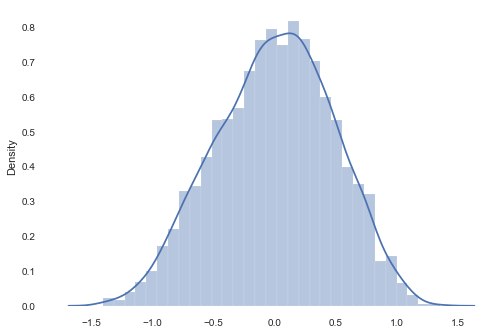

In [91]:
# Checking the linearity of residuals
residuals = train_y_final -train_pred
sns.distplot(residuals)

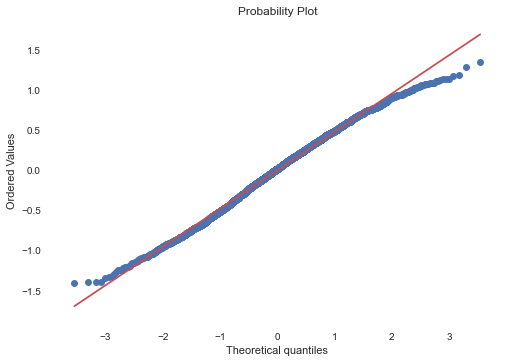

In [92]:
# assumption: Normality of the residuals/error (using Q-Q plot)
from scipy import stats
import pylab

stats.probplot(lm_final.resid, dist = 'norm', plot = pylab)
pylab.show()

In [93]:
# assumption: mean of residuals/errors is zero
print(lm_final.resid.mean().round(6))

0.0


In [94]:
# assumption: residuals/errors of the model should not be correlated with dependant (Y) variable

print(scipy.stats.pearsonr(lm_final.resid, train_y_final))

(0.8210197218078876, 0.0)


###  MSE, MAE, RMSE

In [95]:
# UDF to calculate Mean Absolute Percentage Error
def MAPE(true, pred): 
    true, pred = np.array(true), np.array(pred)
    return np.mean(np.abs((true - pred) / true)) * 100

In [96]:
#UDF to calcuate the Scores(MSE, RMSE, MAPE, MAE for train and test)
def scores(model, testX, trainX, trainy, testy,modelname):
    test_pred = lm1.predict(test_X)
    train_pred = lm1.predict(train_X)
    list1 = [metrics.mean_squared_error(trainy, train_pred),
     metrics.mean_squared_error(testy, test_pred),
     np.sqrt(metrics.mean_squared_error(trainy, train_pred)),
     np.sqrt(metrics.mean_squared_error(testy, test_pred)),
    MAPE(trainy, train_pred),
    MAPE(testy, test_pred),
    metrics.mean_absolute_error(trainy, train_pred),
     metrics.mean_absolute_error(testy, test_pred)]
    scored = pd.DataFrame(list1,
    index= ['MSE-Train', 'MSE-Test', 'RMSE-Train', 'RMSE-Test', 'MAPE-Train', 'MAPE-Test','MAE-Train', 'MAE-Test'], columns= [modelname])
    return scored

In [97]:
score1 = scores(lm_final, test_X_final, train_X_final,train_y_final,test_y_final, 'OLS')
score1

,OLS
MSE-Train,0.228804
MSE-Test,0.224012
RMSE-Train,0.478335
RMSE-Test,0.473299
MAPE-Train,6.623160
MAPE-Test,6.512489
MAE-Train,0.389664
MAE-Test,0.383159


#### Decile Analysis

In [98]:
train = pd.concat([train_X_final, train_y_final], axis =1)
test = pd.concat([test_X_final, test_y_final], axis = 1)
train = sm.add_constant(train)
train['predicted_spent'] = lm_final.predict(train_X_final)
test = sm.add_constant(test)
test['predicted_spent'] = lm_final.predict(test_X_final)

In [99]:
# Decile Analysis for train data
train['Deciles'] = pd.qcut(train['predicted_spent'], 10, labels= False)
predicted_avg = train[['Deciles', 'predicted_spent']].groupby(train.Deciles).mean().sort_index(ascending = False)['predicted_spent']
actual_avg = train[['Deciles', 'ln_total_spent']].groupby(train.Deciles).mean().sort_index(ascending = False)['ln_total_spent']
Decile_analysis_train_ols = pd.concat([predicted_avg, actual_avg], axis= 1).reset_index()
#Decile_analysis_train_ols.to_csv('Decile_Analysis_Train')
Decile_analysis_train_ols.columns = ['Decile_ols', 'Predicted_ols', 'total_spent_ols']
Decile_analysis_train_ols[['Predicted_ols', 'total_spent_ols']] =np.exp(Decile_analysis_train_ols[['Predicted_ols', 'total_spent_ols']])
Decile_analysis_train_ols

,Decile_ols,Predicted_ols,total_spent_ols
0,9,768.618521,778.734625
1,8,592.867751,603.544854
2,7,515.845341,508.989526
3,6,460.514950,444.819688
4,5,414.498160,405.348175
5,4,379.366458,382.800170
6,3,346.465364,342.991594
7,2,318.027879,325.544802
8,1,289.582206,296.008547
9,0,245.311318,244.139028


In [100]:
# Decile Analysis for test data
test['Deciles'] = pd.qcut(test['predicted_spent'], 10, labels= False)
predicted_avg = test[['Deciles', 'predicted_spent']].groupby(test.Deciles).mean().sort_index(ascending = False)['predicted_spent']
actual_avg = test[['Deciles', 'ln_total_spent']].groupby(test.Deciles).mean().sort_index(ascending = False)['ln_total_spent']
Decile_analysis_test_ols = pd.concat([predicted_avg, actual_avg], axis= 1).reset_index()
#Decile_analysis_test.to_csv('Decile_Analysis_Train')
Decile_analysis_test_ols.columns = ['Decile_ols', 'Predicted_ols', 'total_spent_ols']
Decile_analysis_test_ols[['Predicted_ols', 'total_spent_ols']] =np.exp(Decile_analysis_test_ols[['Predicted_ols', 'total_spent_ols']])
Decile_analysis_test_ols

,Decile_ols,Predicted_ols,total_spent_ols
0,9,788.736317,715.046124
1,8,589.534765,551.359369
2,7,516.430883,475.174810
3,6,459.301432,458.632157
4,5,415.920422,449.233745
5,4,378.461624,379.811836
6,3,340.242569,350.035471
7,2,311.180934,317.467850
8,1,283.169407,298.592039
9,0,241.289809,245.418191


### Final Model 2 ( Random Forest) 

In [101]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [102]:
param_grid = {'n_estimators': np.arange(10,30)}

In [103]:
RF_tree = GridSearchCV(RandomForestRegressor(oob_score= False, warm_start= True), param_grid, cv = 2, n_jobs= -1)


In [104]:
RF_tree.fit(train_X_final, train_y_final)

GridSearchCV(cv=2, estimator=RandomForestRegressor(warm_start=True), n_jobs=-1,
             param_grid={'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29])})

In [105]:
estimator= list(RF_tree.best_params_.values())[0]
estimator

21

#### making model on best params:

In [106]:
model4 = RandomForestRegressor( n_estimators = estimator, max_features= 'auto',verbose= True, n_jobs= -1)
model4.fit(train_X_final, train_y_final)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.3s finished


RandomForestRegressor(n_estimators=21, n_jobs=-1, verbose=True)

In [107]:
# Score or the model
model4.score(train_X_final, train_y_final)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:    0.0s finished


0.8772266158937616

In [108]:
df = pd.DataFrame(model4.feature_importances_,index= train_X_final.columns, columns= ['Imp'])
df.sort_values('Imp', ascending= False)

,Imp
lninc,0.267570
lncreddebt,0.149679
age,0.136897
othdebt,0.135549
debtinc,0.116476
card_3,0.037154
card_2,0.032674
card_4,0.028692
card2_2,0.022001
gender_1,0.021469


#### finding MSE, MAE, RMSE

In [109]:
score2 = scores(model4, test_X_final, train_X_final, train_y_final,test_y_final,'RF')
score2.columns = ['RF']
score2

,RF
MSE-Train,0.228804
MSE-Test,0.224012
RMSE-Train,0.478335
RMSE-Test,0.473299
MAPE-Train,6.623160
MAPE-Test,6.512489
MAE-Train,0.389664
MAE-Test,0.383159


#### Decile Analysis

In [110]:
train = pd.concat([train_X_final, train_y_final], axis =1)
test = pd.concat([test_X_final, test_y_final], axis = 1)
train = sm.add_constant(train)
train['predicted_spent'] = model4.predict(train_X_final)
test = sm.add_constant(test)
test['predicted_spent'] = model4.predict(test_X_final)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:    0.0s finished


In [111]:
# Decile Analysis for train data
train['Deciles'] = pd.qcut(train['predicted_spent'], 10, labels= False)
predicted_avg = train[['Deciles', 'predicted_spent']].groupby(train.Deciles).mean().sort_index(ascending = False)['predicted_spent']
actual_avg = train[['Deciles', 'ln_total_spent']].groupby(train.Deciles).mean().sort_index(ascending = False)['ln_total_spent']
Decile_analysis_train_rf = pd.concat([predicted_avg, actual_avg], axis= 1).reset_index()
#Decile_analysis_train_rf.to_csv('Decile_Analysis_Train')
Decile_analysis_train_rf.columns = ['Decile_rf', 'Predicted_rf', 'total_spent_rf']
Decile_analysis_train_rf[['Predicted_rf', 'total_spent_rf']] =np.exp(Decile_analysis_train_rf[['Predicted_rf', 'total_spent_rf']])
Decile_analysis_train_rf

,Decile_rf,Predicted_rf,total_spent_rf
0,9,889.338089,1027.909843
1,8,679.503738,772.019542
2,7,559.009796,614.586186
3,6,485.343369,522.138157
4,5,429.007651,449.699559
5,4,382.447954,387.487207
6,3,339.115285,332.905532
7,2,297.678174,273.817232
8,1,251.894743,217.657364
9,0,189.362234,151.335704


In [112]:
# Decile Analysis for test data
test['Deciles'] = pd.qcut(test['predicted_spent'], 10, labels= False)
predicted_avg = test[['Deciles', 'predicted_spent']].groupby(test.Deciles).mean().sort_index(ascending = False)['predicted_spent']
actual_avg = test[['Deciles', 'ln_total_spent']].groupby(test.Deciles).mean().sort_index(ascending = False)['ln_total_spent']
Decile_analysis_test_rf = pd.concat([predicted_avg, actual_avg], axis= 1).reset_index()
#Decile_analysis_test.to_csv('Decile_Analysis_Train')
Decile_analysis_test_rf.columns = ['Decile_rf', 'Predicted_rf', 'total_spent_rf']
Decile_analysis_test_rf[['Predicted_rf', 'total_spent_rf']] =np.exp(Decile_analysis_test_rf[['Predicted_rf', 'total_spent_rf']])
Decile_analysis_test_rf

,Decile_rf,Predicted_rf,total_spent_rf
0,9,778.534049,665.801526
1,8,595.247808,522.434812
2,7,509.626542,477.525166
3,6,450.025644,439.793516
4,5,408.590163,402.899657
5,4,374.948984,396.180127
6,3,343.403032,342.937119
7,2,315.598720,328.381357
8,1,284.772717,306.825486
9,0,231.618451,296.297776


In [113]:
Decile_Analysis_Test = pd.concat([Decile_analysis_test_ols, Decile_analysis_test_rf], axis = 1)
Decile_Analysis_Train = pd.concat([Decile_analysis_train_ols, Decile_analysis_train_rf], axis =1)
Scores = pd.concat([score1, score2], axis= 1)
Scores.to_excel(writer, 'MSE_MAPE_MAE')
Decile_Analysis_Train.to_excel(writer, 'Decile Train')
Decile_Analysis_Test.to_excel(writer, 'Decile Test')
#Decile_Analysis_Test.to_csv('Test.csv')
#Decile_Analysis_Train.to_csv('Train.csv')

In [114]:
Scores

,OLS,RF
MSE-Train,0.228804,0.228804
MSE-Test,0.224012,0.224012
RMSE-Train,0.478335,0.478335
RMSE-Test,0.473299,0.473299
MAPE-Train,6.623160,6.623160
MAPE-Test,6.512489,6.512489
MAE-Train,0.389664,0.389664
MAE-Test,0.383159,0.383159


In [115]:
Decile_Analysis_Test

,Decile_ols,Predicted_ols,total_spent_ols,Decile_rf,Predicted_rf,total_spent_rf
0,9,788.736317,715.046124,9,778.534049,665.801526
1,8,589.534765,551.359369,8,595.247808,522.434812
2,7,516.430883,475.174810,7,509.626542,477.525166
3,6,459.301432,458.632157,6,450.025644,439.793516
4,5,415.920422,449.233745,5,408.590163,402.899657
5,4,378.461624,379.811836,4,374.948984,396.180127
6,3,340.242569,350.035471,3,343.403032,342.937119
7,2,311.180934,317.467850,2,315.598720,328.381357
8,1,283.169407,298.592039,1,284.772717,306.825486
9,0,241.289809,245.418191,0,231.618451,296.297776


In [116]:
Decile_Analysis_Train

,Decile_ols,Predicted_ols,total_spent_ols,Decile_rf,Predicted_rf,total_spent_rf
0,9,768.618521,778.734625,9,889.338089,1027.909843
1,8,592.867751,603.544854,8,679.503738,772.019542
2,7,515.845341,508.989526,7,559.009796,614.586186
3,6,460.514950,444.819688,6,485.343369,522.138157
4,5,414.498160,405.348175,5,429.007651,449.699559
5,4,379.366458,382.800170,4,382.447954,387.487207
6,3,346.465364,342.991594,3,339.115285,332.905532
7,2,318.027879,325.544802,2,297.678174,273.817232
8,1,289.582206,296.008547,1,251.894743,217.657364
9,0,245.311318,244.139028,0,189.362234,151.335704


### Predicting the Total Spent on Train and test data on model (OLS)

In [117]:
Predict_train = pd.DataFrame()
Predict_train['ln_total_spent'] = np.exp(train_y_final)
Predict_train = pd.concat([train_X_final,Predict_train], axis = 1)
Predict_train['ln_total_spent_predicted'] = np.exp(lm_final.predict(train_X_final))
Predict_train.to_excel(writer, 'Prediction_Train')
Predict_train

,age,card2_2,card2_3,card2_4,card_2,card_3,card_4,card_5,debtinc,gender_1,lncreddebt,lninc,othdebt,ln_total_spent,ln_total_spent_predicted
4361,21,1,0,0,0,0,0,0,7.5,0,-1.217058,3.332205,1.803900,831.89,573.558780
2519,29,0,0,1,0,0,0,0,7.8,1,-0.100731,3.178054,0.967824,534.07,517.659888
4837,27,1,0,0,0,1,0,0,11.6,0,-1.336149,3.091042,2.289144,313.49,292.549803
1334,57,1,0,0,0,0,1,0,15.3,0,0.067592,4.709530,11.815981,308.10,465.834324
719,25,0,0,0,0,0,1,0,7.2,1,-1.279386,2.639057,0.729792,341.05,321.918345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,22,0,0,1,0,0,0,0,3.1,0,-1.453546,2.995732,0.386260,488.83,511.415440
1564,55,1,0,0,0,0,1,0,5.5,0,-0.219675,4.488636,4.092220,797.48,418.981583
972,62,0,1,0,1,0,0,0,1.9,0,-1.714088,3.465736,0.287692,365.63,312.174427
2645,62,0,0,0,0,0,1,0,7.7,0,0.237591,4.499810,5.661810,416.82,577.430965


In [118]:
Predict_test = pd.DataFrame()
Predict_test['ln_total_spent'] = np.exp(test_y_final)
Predict_test = pd.concat([test_X_final,Predict_test], axis = 1)
Predict_test['ln_total_spent_predicted'] = np.exp(lm_final.predict(test_X_final))
Predict_test.to_excel(writer, 'Prediction_Test')
Predict_test

,age,card2_2,card2_3,card2_4,card_2,card_3,card_4,card_5,debtinc,gender_1,lncreddebt,lninc,othdebt,ln_total_spent,ln_total_spent_predicted
4133,35,0,0,0,0,1,0,0,10.8,1,0.129269,3.713572,3.290004,539.050000,472.021127
3771,47,0,0,1,0,0,0,0,11.1,1,1.852297,4.727388,5.857581,1145.146489,841.694561
26,26,0,0,0,0,0,1,0,11.7,1,0.260282,3.178054,1.510704,548.670000,383.054254
2049,51,0,0,1,0,1,0,0,7.2,0,-1.244295,3.367296,1.799856,308.170000,301.301165
3385,57,0,0,1,0,0,0,0,11.3,0,1.852297,4.990433,10.292040,535.550000,982.343991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4001,31,0,0,1,0,0,0,0,3.2,1,-1.152520,3.044522,0.356160,399.300000,490.958363
2946,47,0,0,1,0,0,0,0,8.1,0,0.311875,4.127134,3.656016,618.770000,707.696130
4987,49,0,1,0,0,0,1,0,13.8,1,0.031063,3.218876,2.418450,421.520000,272.765209
2533,75,0,0,1,1,0,0,0,4.4,0,-1.591873,2.890372,0.588456,237.230000,251.597229


### Key Variables 

In [119]:
ranks = {}
def rank_to_dic(ranks, var, order =1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(var, ranks))


In [120]:
import warnings
warnings.filterwarnings('ignore', category= DeprecationWarning)

sel_var = list(final_var3)

lr = LinearRegression(normalize= True)
lr.fit(train_X_final, train_y_final)
ranks['LinearRegression'] = rank_to_dic(np.abs(lr.coef_), sel_var)

ridge =  Ridge()
ridge.fit(train_X_final, train_y_final)
ranks['Ridge'] = rank_to_dic(np.abs(ridge.coef_), sel_var)


lasso =  Lasso()
lasso.fit(train_X_final, train_y_final)
ranks['Lasso'] = rank_to_dic(np.abs(lasso.coef_), sel_var)

rfe = RFE(lr, n_features_to_select=20)
rfe.fit(train_X_final, train_y_final)
ranks["RFE"] = rank_to_dic(list(map(float, rfe.ranking_)), sel_var, order=-1)

rf =  RandomForestRegressor()
rf.fit(train_X_final, train_y_final)
ranks['RandomForest'] = rank_to_dic(rf.feature_importances_, sel_var)
 


f, pval =  f_regression(train_X_final, train_y_final, center= True)
ranks['F_Regression'] = rank_to_dic(f, sel_var)

r = {}
for var in sel_var:
    r[var] = round(np.mean([ranks[method][var] for method in ranks.keys()]), 2)
    
    
methods = sorted(ranks.keys())
ranks['mean'] = r
methods.append('mean')

ranks_df = pd.DataFrame(data= ranks).sort_values('mean', ascending = False)

ranks_df.to_excel(writer, 'Key Drivers')

ranks_df

,LinearRegression,Ridge,Lasso,RFE,RandomForest,F_Regression,mean
lninc,0.42,0.42,0.0,0.0,1.00,1.00,0.47
card_4,1.00,1.00,0.0,0.0,0.05,0.02,0.34
card_2,0.91,0.91,0.0,0.0,0.07,0.10,0.33
card_3,0.91,0.91,0.0,0.0,0.09,0.06,0.33
card_5,0.74,0.73,0.0,0.0,0.00,0.01,0.25
card2_4,0.52,0.52,0.0,0.0,0.00,0.02,0.18
card2_2,0.49,0.49,0.0,0.0,0.02,0.02,0.17
card2_3,0.47,0.47,0.0,0.0,0.02,0.06,0.17
lncreddebt,0.05,0.05,0.0,0.0,0.53,0.38,0.17
othdebt,0.02,0.02,0.0,0.0,0.47,0.44,0.16


<AxesSubplot:ylabel='mean'>

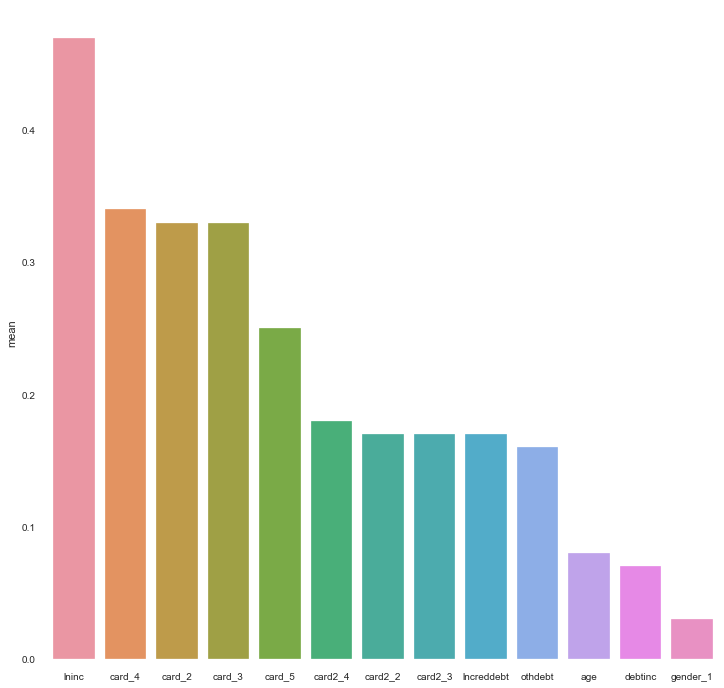

In [121]:
plt.figure(figsize= (12,12))
sns.barplot(x= ranks_df.index, y = ranks_df['mean'] )

In [122]:
writer.save()